## Gaussian Processes to Model the Relationship between Vaccinations and Excess Mortality

The vaccination offer an amazing protection against severe cases of COVID-19 and were able to widen the gap between infections and mortalities. We want to visualize this by modeling a Gaussian Process over the rate of fully vaccinated people and the excess mortality in different countries.

In [1]:
# Make inline plots vector graphics
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

# Plotting setup
import matplotlib.pyplot as plt

# Package imports
import numpy as np
import pandas as pd
import datetime
from tueplots import bundles
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Set Pyplot parameters to Neurips template
plt.rcParams.update(bundles.neurips2021(usetex=False))

We start by downloading the COVID data set from [OurWorldInData.org](https://github.com/owid/covid-19-data/tree/master/public/data).

In [2]:
# Link to world-wide data during the COVID pandemic
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

# Read CSV data from URL
data_owid = pd.read_csv(url)

# Parse data
data_owid["date"] = pd.to_datetime(data_owid.date, format="%Y-%m-%d")

# Inspect dataframe and datatypes
display(data_owid.head())
data_owid.dtypes[0:5]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


iso_code               object
continent              object
location               object
date           datetime64[ns]
total_cases           float64
dtype: object

Next, we extract the relevant columns, which are:
- excess_mortality: Percentage difference between the reported number of weekly or monthly deaths in 2020–2021 and the projected number of deaths for the same period based on previous years. 
- people_fully_vaccinated_per_hundred: Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population

Since the excess mortality uses percentages, it is no major problem that we are mixing data reported weekly and monthly

In [3]:
# Remove columns, that are not needed
newcols = [
    "date",
    "iso_code",
    "excess_mortality",
    "people_fully_vaccinated_per_hundred"
]
data_owid.drop(columns=data_owid.columns.difference(newcols), inplace=True)

print("Shape prior to dropping NaN: ", data_owid.shape)
print("Number of countries: ", len(data_owid.iso_code.unique()))

# Remove entries with missing data
data_owid.dropna(inplace=True)
print("Shape after dropping NaN: ", data_owid.shape)
print("Number of countries: ", len(data_owid.iso_code.unique()))

data_owid.head()

Shape prior to dropping NaN:  (159553, 4)
Number of countries:  238
Shape after dropping NaN:  (2060, 4)
Number of countries:  84


,iso_code,date,people_fully_vaccinated_per_hundred,excess_mortality
1896,ALB,2021-05-31,10.11,10.81
1926,ALB,2021-06-30,14.05,-6.24
1957,ALB,2021-07-31,18.40,3.52
1988,ALB,2021-08-31,22.34,21.72
2018,ALB,2021-09-30,27.67,43.50


After extracting and inspecting the data, we can split it into the feature and target. Gaussian processes also assume zero centered data and hyperparameter tuning is easier as well, so we standardize the excess mortality to N(0,1). We save the mean and std, which will be later used to scale the predictions back.

In [4]:
# Split data
X = data_owid["people_fully_vaccinated_per_hundred"].values
X = X.reshape(-1, 1)
y = data_owid["excess_mortality"].values

# Normalize target
y_mean = y.mean()
y_std = y.std()

y_norm = (y - y_mean) / y_std

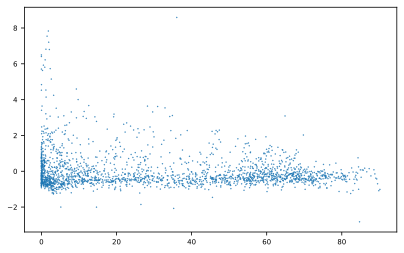

In [5]:
# Scatter plot for a first impression of the relationship
plt.scatter(X, y_norm, s=0.2)

plt.show()

In [7]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e2, noise_level_bounds=(1e-3, 1e3)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=100, normalize_y=True)
gpr.fit(X[:10], y[:10])
gpr.kernel_

0.981**2 * RBF(length_scale=0.0108) + WhiteKernel(noise_level=0.037)

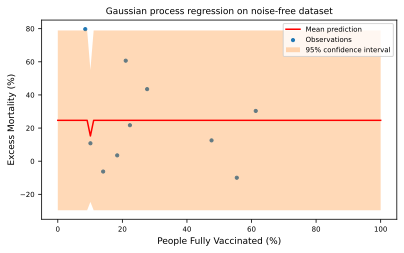

In [8]:
linspace = np.linspace(0, 100, 100).reshape(-1, 1)
mean_prediction, std_prediction = gpr.predict(linspace, return_std=True)

plt.scatter(X[:10], y[:10], label="Observations", s=10)
plt.plot(linspace, mean_prediction, label="Mean prediction", c="r")
plt.fill_between(
    linspace.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.3,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("People Fully Vaccinated (%)")
plt.ylabel("Excess Mortality (%)")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [12]:
from matplotlib.colors import LogNorm

length_scale = np.logspace(-3, 3, num=100)
noise_level = np.logspace(-2, 2, num=100)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

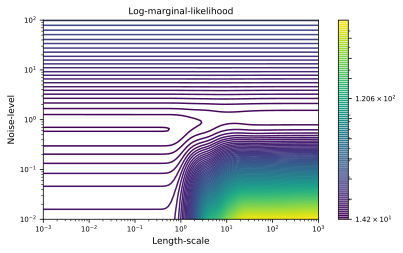

In [13]:
vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=100), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

Gaussian Processes seemed like a good idea to model this distribution. However, the data set is so noisy, that the model is very difficult to optimise. I was not able to find a good solution.